# 03 Adding a sphere

* 구(sphere)를 정의하고 ray가 구를 통과하는지를 확인하는 예제 입니다.

In [2]:
import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt

In [3]:
def normalize(vec: np.array, eps: float = 1e-6):
    return vec / (LA.norm(vec) + eps)


def blend(color1: np.array, color2: np.array, t: float):
    return (1.0 - t) * color1 + t * color2

In [4]:
class Ray:
    def __init__(self, origin: np.array, direction: np.array) -> None:
        self.origin: np.array = origin
        self.direction: np.array = normalize(direction)

    def at(self, t: float) -> np.array:
        return self.origin + t * self.direction

### 구의 방정식
* 중심이 원점에 있고 반지름이 r인 구의 방정식은 $x^2 + y^2 + z^2 = r^2$으로 나타냅니다.
  * 한 점 $(x, y, z)$가 구의 표면에 위치하는 경우에만 $x^2 + y^2 + z^2 = r^2$가 성립합니다.
  * 한 점 $(x, y, z)$가 구의 위부에 위치한다면 $x^2 + y^2 + z^2 > r^2$가 되고 반대로 구의 내부에 위치한다면 $x^2 + y^2 + z^2 < r^2$가 됩니다.
* 구의 중심이 $[C_x, C_y, C_z]^\intercal$에 있다면 구의 방정식은 다음과 같이 나타낼수 있습니다.
$$(x-C_x)^2 + (y-C_y)^2 + (z-C_z)^2 = r^2$$
* $\mathbf{C} = (C_x, C_y, C_z)$에서 $\mathbf{P} = (x, y, z)$로 향하는 벡터가 있을때 다음과 같이 나타낼 수 있습니다.
$$(\mathbf{P}-\mathbf{C}) \cdot (\mathbf{P}-\mathbf{C}) = (x - C_x)^2 + (y - C_y)^2 + (z - C_z)^2$$
* 위의 식을 벡터 형식으로 정리하면 $(\mathbf{P}-\mathbf{C}) \cdot (\mathbf{P}-\mathbf{C}) = r^2$가 됩니다.
  * 위의 식을 만족하는 모든 점 $\mathbf{P}$는 구의 표면에 위치 합니다.

### 구와 ray
* 여기서는 Ray가 구와 만나는지 알아보려 합니다.
  * Ray를 $\mathbf{A} + t\mathbf{b} = \mathbf{P}(t)$와 같이 $t$에 대한 함수로 나타낼 수 있습니다.
    * $\mathbf{A}$는 ray의 시작점, $\mathbf{b}$는 ray의 방향을 나타냅니다.
  * 특정 $t$에 대해서 $\mathbf{P}(t)$가 구의 방정식을 만족한다면 ray과 구와 만난다고 할 수 있습니다.
* 다음의 수식 $(\mathbf{P}(t)-\mathbf{C}) \cdot (\mathbf{P}(t)-\mathbf{C}) = r^2$을 만족하는 $t$를 찾습니다.
  * 위의 수식에서 $\mathbf{P}(t)$를 전개하면 다음과 같습니다.
$$(\mathbf{A} + t\mathbf{b}-\mathbf{C}) \cdot (\mathbf{A} + t\mathbf{b}-\mathbf{C}) = r^2$$
  * 위의 수식을 정리하고 대수를 모두 좌측으로 옮기면 다음과 같습니다.
$$ t^2 \mathbf{b} \cdot \mathbf{b} + 2t\mathbf{b} \cdot (\mathbf{A} - \mathbf{C}) + (\mathbf{A} - \mathbf{C}) \cdot (\mathbf{A} - \mathbf{C}) - r^2 = 0$$

<center>
<img src="./images/ray_and_sphere.png" width="500px" height="350px" title="broadcasting"/>
</center>

### 근의 공식
$$ax^2 + bx + c = 0$$
* $a = \mathbf{b} \cdot \mathbf{b}$
* $b = 2 \mathbf{b} \cdot (\mathbf{A} - \mathbf{C})$
* $c = (\mathbf{A} - \mathbf{C}) \cdot (\mathbf{A} - \mathbf{C}) - r^2$
$$x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$
* 판별식: $b^2 - 4ac$
  * $b^2 - 4ac < 0$: 근 없음
  * $b^2 - 4ac = 0$: 근 하나
  * $b^2 - 4ac > 0$: 근 두 개

In [5]:
def is_hit_sphere(center: np.array, radius: float, ray: Ray):
    dir_center_to_origin = ray.origin - center

    a = np.dot(ray.direction, ray.direction)
    b = 2.0 * np.dot(dir_center_to_origin, ray.direction)
    c = np.dot(dir_center_to_origin, dir_center_to_origin) - radius**2.0

    discriminant = b**2 - 4 * a * c
    return discriminant >= 0

### 근의 공식 간단화

위의 근의 공식을 간단하게 만들어서 계산량을 줄일 수 있습니다.

$$\frac{-b \pm \sqrt{b^2 - 4ac}}{2a}$$
$b$를 $2h$로 치환합니다.
$$ = \frac{-2h \pm \sqrt{(2h)^2 - 4ac}}{2a}$$
근 안의 2를 근 밖으로 뺄수입니다.
$$ = \frac{-2h \pm 2\sqrt{h^2 - ac}}{2a}$$
분모와 분자의 함께 2를 소거합니다.
$$ = \frac{-h \pm \sqrt{h^2 - ac}}{a}$$

* $h$에서 $b$로 치환하면 두 번의 곱하기 연산이 줄어듭니다.
  * $b = 2 \mathbf{b} \cdot (\mathbf{A} - \mathbf{C})$
  * $h = \mathbf{b} \cdot (\mathbf{A} - \mathbf{C})$

* 최종 판별식은 $h^2 - ac$ 가 됩니다.
  * $h^2 - ac < 0$: 근 없음
  * $h^2 - ac = 0$: 근 하나
  * $h^2 - ac > 0$: 근 두 개  

In [6]:
def is_hit_sphere(center: np.array, radius: float, ray: Ray):
    dir_center_to_origin = ray.origin - center

    a = np.dot(ray.direction, ray.direction)
    half_b = np.dot(dir_center_to_origin, ray.direction)
    c = np.dot(dir_center_to_origin, dir_center_to_origin) - radius**2.0

    discriminant = half_b**2 - a * c
    return discriminant >= 0

* ray_color 함수
  * ray가 구와 만나면 구의 색을 반환
  * ray가 구와 만나지 않으면 배경의 색을 반환

In [7]:
def ray_color(ray: Ray) -> np.array:
    sphere_center = np.array([0, 0, -1])
    if is_hit_sphere(center=sphere_center, radius=0.5, ray=ray):
        return np.array([1.0, 0.0, 0.0])

    t = 0.5 * (ray.direction[1] + 1.0)
    color1 = np.array([1.0, 1.0, 1.0])
    color2 = np.array([0.5, 0.7, 1.0])
    return blend(color1=color1, color2=color2, t=t)

이후의 구현은 이전 챕터와 동일합니다.

In [8]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)

image = np.zeros([image_height, image_width, 3])

In [9]:
# camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

camera_origin = np.array([0.0, 0.0, 0.0])
horizontal_vec = np.array([viewport_width, 0.0, 0.0])
vertical_vec = np.array([0.0, viewport_height, 0.0])
backward_vec = np.array([0.0, 0.0, focal_length])
lower_left_corner = (
    camera_origin - horizontal_vec / 2.0 - vertical_vec / 2.0 - backward_vec
)

pixel_delta_u = horizontal_vec / image_width
pixel_delta_v = vertical_vec / image_height

In [10]:
%%time

for row in range(image_height):
  for col in range(image_width):
    u = col + 0.5
    v = row + 0.5

    ray = Ray(origin=camera_origin,
              direction=(lower_left_corner + u*pixel_delta_u + v*pixel_delta_v) - camera_origin)

    image[row, col] = ray_color(ray)

CPU times: user 1.74 s, sys: 23.1 ms, total: 1.76 s
Wall time: 1.79 s


이전 챕터의 그라데이션 배경의 가운데에 빨간색 원이 그려집니다.

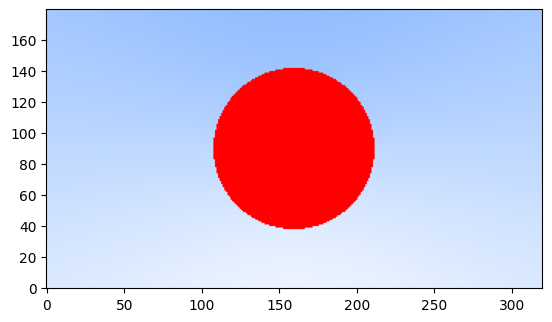

In [11]:
plt.imshow(image, origin="lower")
plt.show()